## Import Libraries

In [5]:
!pip install pytube

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.3 MB/s eta 0:00:00


In [6]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from pytube import YouTube

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [3]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# 1. Download and visualize data

In [58]:
%%capture

!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

!unrar x UCF50.rar

In [ ]:
plt.figure(figsize = (20,20))
video_read = cv2.VideoCapture('UCF50/')

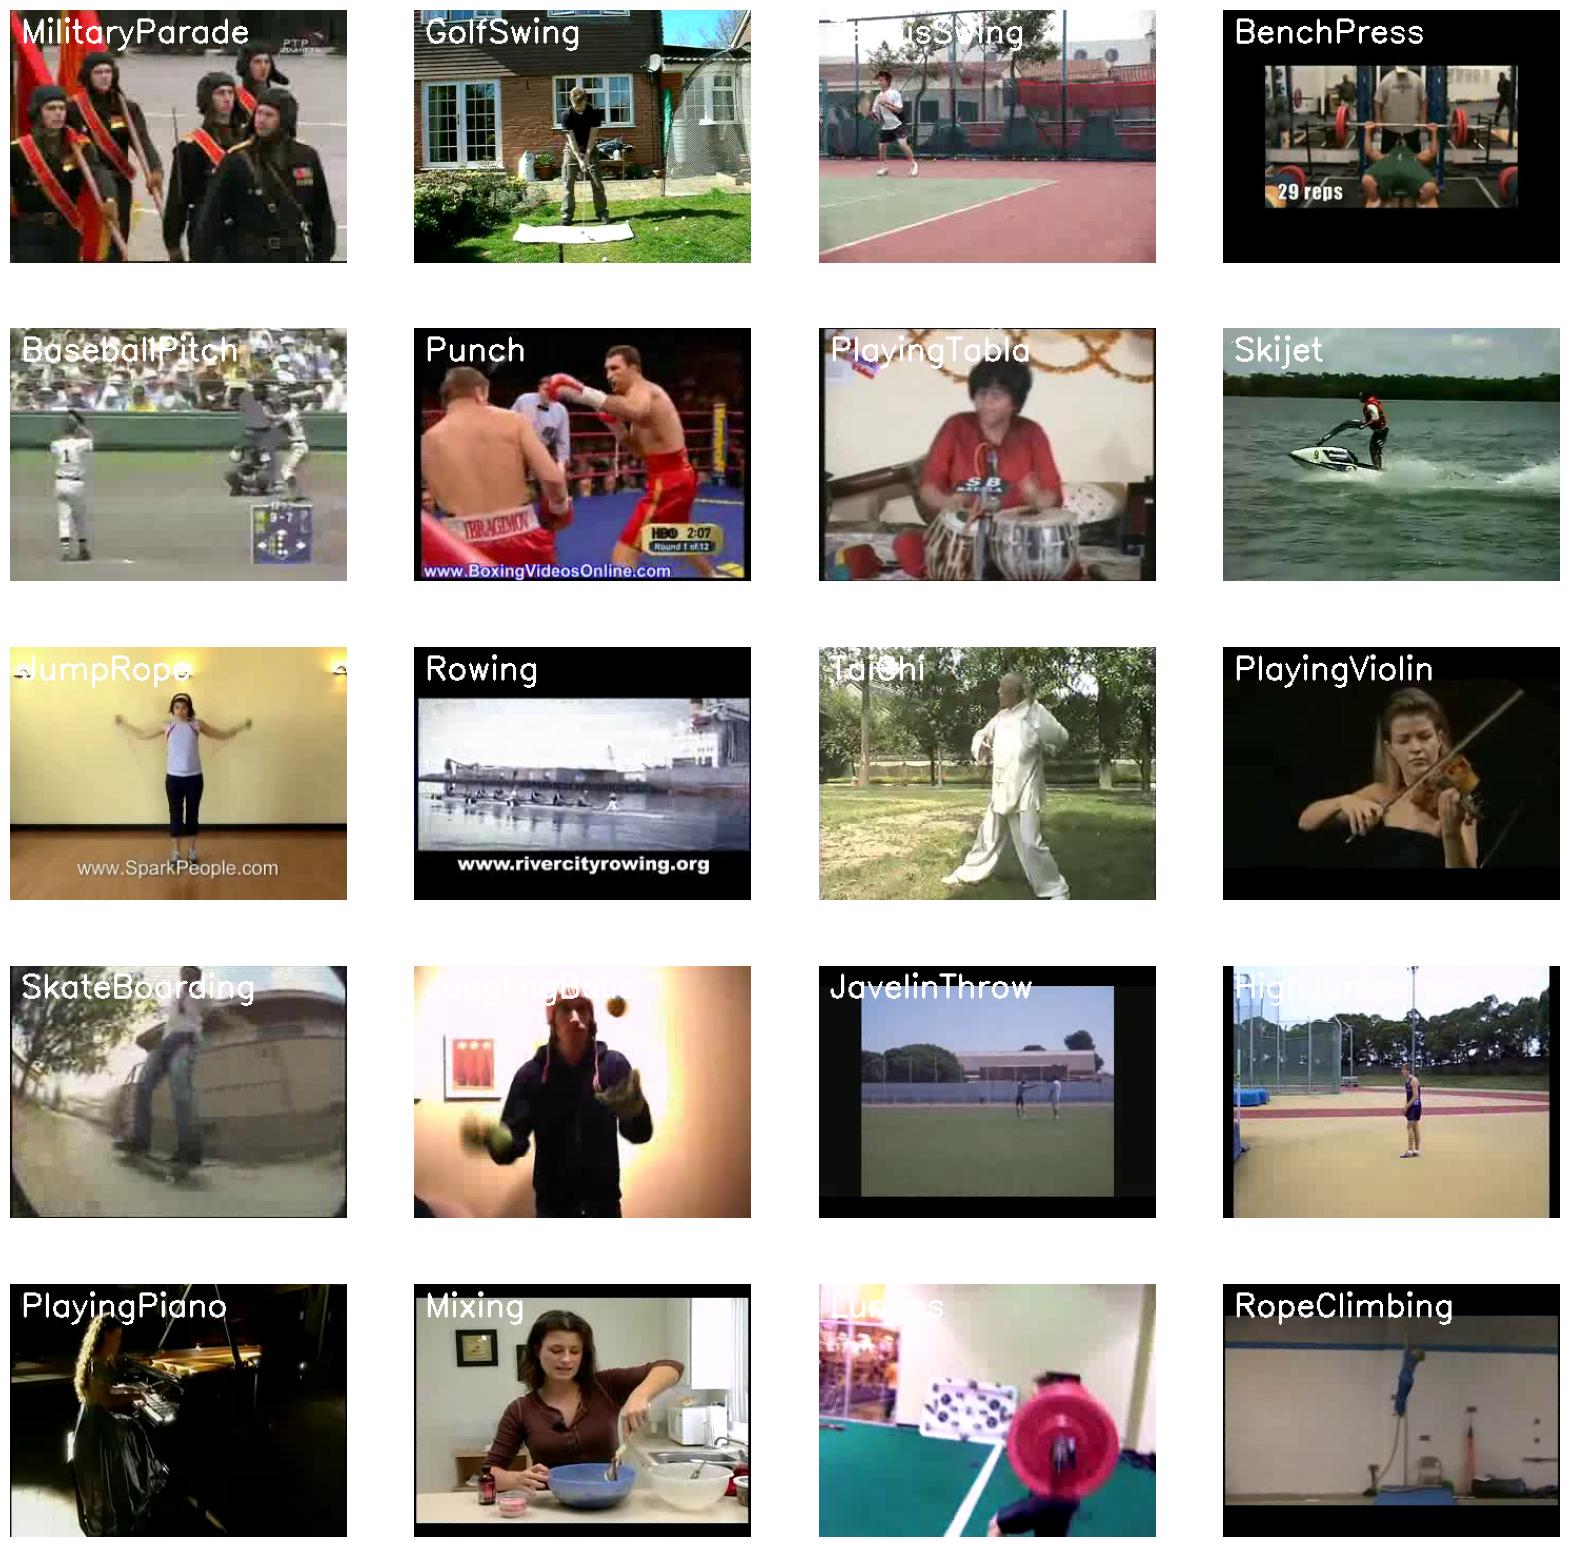

In [59]:
plt.figure(figsize = (20, 20))

all_classes_names = os.listdir('UCF50')

random_range = random.sample(range(len(all_classes_names)), 20)

for counter, random_index in enumerate(random_range, 1):
  selected_class_Name = all_classes_names[random_index]

  # all the video files for selected_class_Name
  video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

  # randomly select video file from list of videos
  selected_video_file_name = random.choice(video_files_names_list)

  # read video by creating a VideoCapture object
  video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

  # read the first frame of the video file
  _, bgr_frame = video_reader.read()

  video_reader.release()

  # convert BGR to RGB
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

  # write class name on video frame
  cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)


  # display frame
  plt.subplot(5, 4, counter)
  plt.imshow(rgb_frame)
  plt.axis('off')

# 2. Preprocess Dataset


In [10]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

# number of frames of a video that will be fed to the model as a sequence
SEQUENCE_LENGTH = 20

DATASET_DIR = 'UCF50'

CLASSES_LIST = ["Punch", "JavelinThrow", "Fencing", "TaiChi"]

In [7]:
def frames_extraction(video_path):
  '''
  This function extracts the required frames from a video after resizing and normalizing them
  Args:
    video_path: The path of the video in the disk, whose frames are to be extracted
  Returns:
    frames_list: A list containing the resized and normalized frames of the video
  '''


  frames_list = []

  video_reader = cv2.VideoCapture(video_path)

  # get total # of frames in the video
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  # calculate the interval of retrieving frames from the video
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

  for frame_counter in range(SEQUENCE_LENGTH):

    # set the current frame position of the video
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

    success, frame = video_reader.read()

    if not success:
      break

    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

    normalized_frame = resized_frame / 255

    frames_list.append(normalized_frame)

  video_reader.release()

  return frames_list

In [8]:
# video_reader = cv2.VideoCapture('UCF50/BaseballPitch/v_BaseballPitch_g01_c01.avi')
# video_reader.set(cv2.CAP_PROP_POS_FRAMES, 100)
# success, frame = video_reader.read()
# video_reader.release()
# if success:
#   rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#   plt.imshow(rgb_frame)

In [9]:
def create_dataset():
  '''
    This function will extract the data of the selected classes and create the required dataset
    Returns:
      features:         List with extracted frames of the videos
      labels:           List with indexes of the classes associated with the videos
      video_file_paths: List with paths of the videos in the disk
  '''
  features = []
  labels = []
  video_files_paths = []

  # go through all classes
  for class_index, class_name in enumerate(CLASSES_LIST):
    print(f'Extracting Data of Class: {class_name}')

    # get list of video files in the class directory
    files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

    # go through all files
    for file_name in files_list:

      # get video path
      video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

      frames = frames_extraction(video_file_path)

      if len(frames) == SEQUENCE_LENGTH:
        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)

  features = np.asarray(features) # reference
  labels = np.array(labels) # copy

  return features, labels, video_files_paths


In [10]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Punch
Extracting Data of Class: JavelinThrow
Extracting Data of Class: Fencing
Extracting Data of Class: TaiChi


In [11]:
# Keras's to_categorical method converts labels into on-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [12]:
one_hot_encoded_labels

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

# 3. Split the Data into training and testing set


In [13]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True, random_state = seed_constant)

# 4. Implement the ConvLSTM



In [14]:
def create_convlstm_model():
  '''
    This function constructs the required convlstm model
    returns:
      model: convlst model
  '''

  model = Sequential()

  model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                       recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                    IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format= 'channels_last'))
  model.add(TimeDistributed(Dropout(0.2))) # 20% of nodes are set to 0 randomly to prevent overfitting
  # TimeDistributed applies Dropout to all frames in video sequence

  model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                       recurrent_dropout=0.2, return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format= 'channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                       recurrent_dropout=0.2, return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format= 'channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                       recurrent_dropout=0.2, return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format= 'channels_last'))

  model.add(Flatten())

  model.add(Dense(len(CLASSES_LIST), activation = 'softmax')) # output layer

  model.summary()

  return model



In [15]:
convlstm_model = create_convlstm_model()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3  (None, 20, 31, 31, 4)     0         
 D)                                                              
                                                                 
 time_distributed (TimeDist  (None, 20, 31, 31, 4)     0         
 ributed)                                                        
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 20, 15, 15, 8)     0         
 g3D)                                                            
                                                        

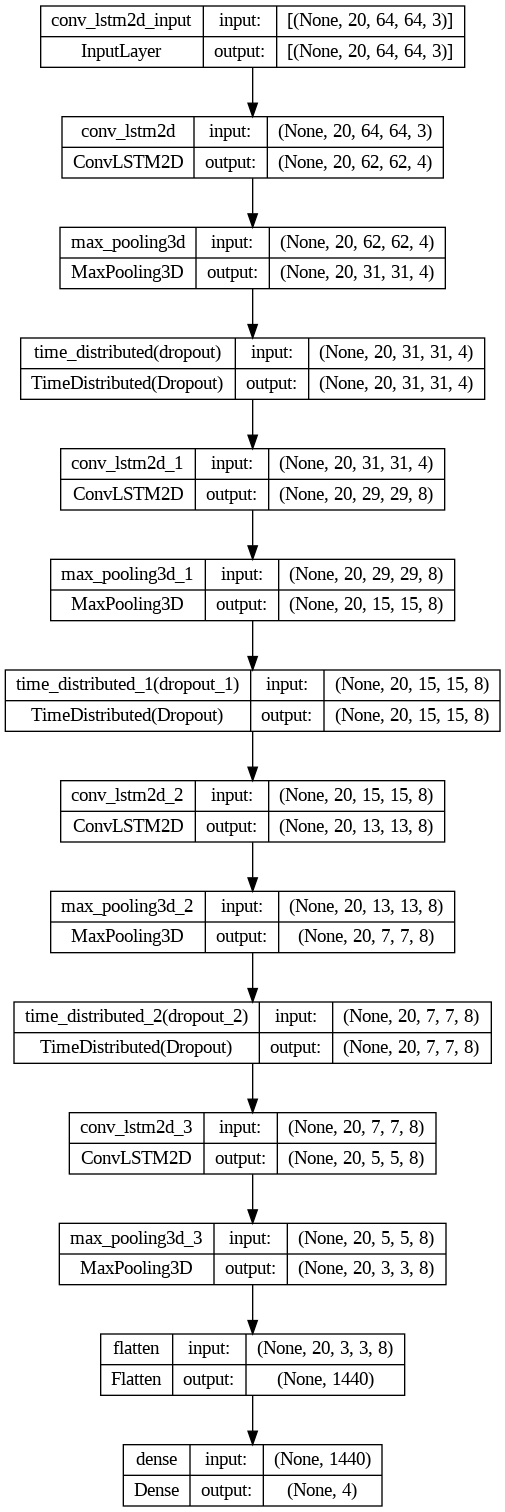

In [16]:
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [17]:
# monitor: when validation loss stop improving for, patience (10) epochs. mode: aim for minimum loss. restore_best_weights: keep the best weights throughout each epoch
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# categorical_crossentropy is good for multiclassification
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4, shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
73/73 [==============================] - 126s 2s/step - loss: 1.3248 - accuracy: 0.3973 - val_loss: 1.1369 - val_accuracy: 0.5541
Epoch 2/50
73/73 [==============================] - 114s 2s/step - loss: 1.0188 - accuracy: 0.5925 - val_loss: 1.0214 - val_accuracy: 0.5811
Epoch 3/50
73/73 [==============================] - 117s 2s/step - loss: 0.8851 - accuracy: 0.6027 - val_loss: 1.0297 - val_accuracy: 0.5405
Epoch 4/50
73/73 [==============================] - 116s 2s/step - loss: 0.7403 - accuracy: 0.7123 - val_loss: 0.6564 - val_accuracy: 0.7432
Epoch 5/50
73/73 [==============================] - 114s 2s/step - loss: 0.6946 - accuracy: 0.7397 - val_loss: 0.5027 - val_accuracy: 0.8514
Epoch 6/50
73/73 [==============================] - 116s 2s/step - loss: 0.5713 - accuracy: 0.7774 - val_loss: 0.6239 - val_accuracy: 0.7027
Epoch 7/50
73/73 [==============================] - 114s 2s/step - loss: 0.5073 - accuracy: 0.8048 - val_loss: 0.5494 - val_accuracy: 0.7162
Epoch 8/50
73

In [18]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

4/4 [==============================] - 12s 3s/step - loss: 0.5209 - accuracy: 0.8607


In [19]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history


date_time_format = '%Y_%n_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'convlstm_model__Date_time_{current_date_time_string}__loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'

convlstm_model.save(model_file_name)

  saving_api.save_model(



In [20]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
  '''
    This function plots model metrics in a graph
    Args:
      model_training_history: History object with record of training and validation loss values and accuracy for each epoch
      metric_name_1:          Name of the first metric to be plotted on the graph
      metric_name_1:          Name of the second metric to be plotted on the grpah
      plot_name:              Title of graph
  '''

  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  epochs = range(len(metric_value_1))

  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'blue', label = metric_name_2)


  plt.title(str(plot_name))

  plt.legend()


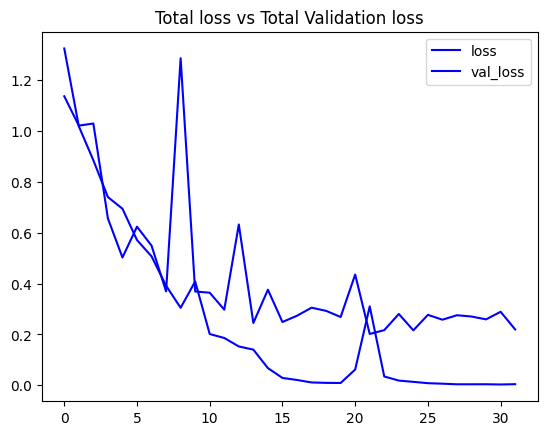

In [21]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total loss vs Total Validation loss')



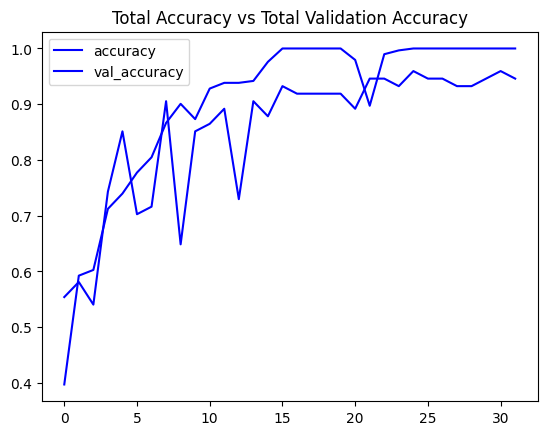

In [22]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [1]:
def download_youtube_videos(youtube_video_url, output_directory):
  '''
  Downloads a youtube video based on its URL
  Args:
    youtube_video_url: URL of youtube video to be downloaded
    output_directory: directory to store the video in
  Returns:
    title: title of the youtube video
  '''

  video = YouTube(youtube_video_url)
  video = video.streams.get_highest_resolution()
  try:
      video.download(output_path = output_directory)
  except:
      print("An error has occurred")
  print("Download is completed successfully")
  return video.title

In [33]:
loaded_model = tf.keras.models.load_model('convlstm_model__Date_time_2023___11__22_51_25__loss_0.5208770036697388__Accuracy_0.8606557250022888.h5')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3  (None, 20, 31, 31, 4)     0         
 D)                                                              
                                                                 
 time_distributed (TimeDist  (None, 20, 31, 31, 4)     0         
 ributed)                                                        
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 20, 15, 15, 8)     0         
 g3D)                                                            
                                                        

In [60]:
# test_videos_directory = 'test_videos'
# os.makedirs(test_videos_directory, exist_ok = True)

input_video_file_path = 'punch_video.avi'

In [52]:
def predict_action(video_file_path, SEQUENCE_LENGTH):
  '''
  This function will predict that action being performed in the video
  Args:
    video_file_path:  Path of the video stored in the disk
    SEQUENCE_LENGTH:  Fixed number of frames of a video that can be passed to the model as one sequence
  '''

  video_reader = cv2.VideoCapture(video_file_path)

  original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
  original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

  frames_list = []

  predicted_class_name = ''

  # Get the number of frames in the video.
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  # Calculate the interval after which frames will be added to the list.
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

  # Iterating the number of times equal to the fixed length of sequence.
  for frame_counter in range(SEQUENCE_LENGTH):

    # Set the current frame position of the video.
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

    # Read a frame.
    success, frame = video_reader.read()

    # Check if frame is not read properly then break the loop.
    if not success:
        break

    # Resize the Frame to fixed Dimensions.
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

    # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
    normalized_frame = resized_frame / 255

    # Appending the pre-processed frame into the frames list
    frames_list.append(normalized_frame)

  # Passing the  pre-processed frames to the model and get the predicted probabilities.
  predicted_labels_probabilities = loaded_model.predict(np.expand_dims(frames_list, axis = 0))[0]

  # Get the index of class with highest probability.
  predicted_label = np.argmax(predicted_labels_probabilities)

  # Get the class name using the retrieved index.
  predicted_class_name = CLASSES_LIST[predicted_label]

  # Display the predicted action along with the prediction confidence.
  print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

  # Release the VideoCapture object.
  video_reader.release()


In [64]:
predict_action('punch_video.avi', SEQUENCE_LENGTH)

1/1 [==============================] - 0s 126ms/step
Action Predicted: Punch
Confidence: 0.992598295211792
